In [9]:
from Mc2PCA_class import Mc2PCA
import numpy as np
from sktime.datasets import load_japanese_vowels
import matplotlib.pyplot as plt 
import pandas as pd
# import train_test_split
from tqdm import tqdm


In [2]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.stats import mode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, classes):
    # Aligner les étiquettes de cluster avec les vraies étiquettes
    labels = np.zeros_like(y_pred)
    for i in range(max(y_pred) + 1):
        mask = (y_pred == i)
        if np.sum(mask) > 0:
            # Trouver le mode en utilisant np.unique
            unique, counts = np.unique(y_true[mask], return_counts=True)
            labels[mask] = unique[np.argmax(counts)]

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_true, labels)
    # print(conf_matrix)

    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(y_true, y_pred, labels=classes)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=classes, yticklabels=classes)
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.show()

def compute_precision(C, G):
    """
    Compute the precision of clustering as described in the provided formula.
    
    C is a list of numpy arrays, where each array represents the indices of MTS objects in the jth predicted cluster.
    G is a list of sets, where each set contains the indices of MTS objects in the ith true group.
    
    Parameters:
    - C: A list of numpy arrays representing the predicted clusters.
    - G: A list of sets representing the true groups.
    
    Returns:
    - The precision of the clustering.
    """
    N = sum(len(c) for c in C)  # Total number of MTS objects
    precision = 0.0
    
    for cj in C:
        cj_set = set(cj)
        max_intersection = max(len(cj_set.intersection(gi)) for gi in G)
        # if len(cj) == 0:
        #     continue  # Ignore les clusters vides
        precision += (len(cj) / N) * (max_intersection / len(cj))
        
    return precision

def compute_recall(C, G):
    """
    Compute the recall of clustering.
    
    C is a list of numpy arrays, where each array represents the indices of MTS objects in the jth predicted cluster.
    G is a list of sets, where each set contains the indices of MTS objects in the ith true group.
    
    Parameters:
    - C: A list of numpy arrays representing the predicted clusters.
    - G: A list of sets representing the true groups.
    
    Returns:
    - The recall of the clustering.
    """
    N = sum(len(g) for g in G)  # Total number of MTS objects
    recall = 0.0
    
    for gi in G:
        gi_set = set(gi)
        max_intersection = max(len(gi_set.intersection(cj)) for cj in C)
        recall += (len(gi) / N) * (max_intersection / len(gi))
        
    return recall

def get_p_max(X, K, y_test, metric = "precision", seuil = 1e-7, max_iter = 50):
    nbre_features = X.shape[1] # Works for DataFrame and numpy array

    idx_test = [np.where(y_test == str(i))[0] for i in range(1,np.max(y_test.astype(int))+1)]
    y_estimate = None
    val = np.inf
    values = []
    p_opt = 0
    for p in range(1, nbre_features):
        model = Mc2PCA(K, p, seuil, max_iter=max_iter)
        idx_estimate, _, _ = model.fit(X)
        if metric=="precision":
            precision = compute_precision(idx_estimate, idx_test)
            values.append(precision)
        if metric=="ARI":
            y_estimate = np.arange(len(y_test))
            for i in range(len(idx_estimate)):
                y_estimate[idx_estimate[i]] = i + 1 
            ari_score = adjusted_rand_score(y_test.astype(int), y_estimate)
            values.append(ari_score)
    values = np.array(values)
    return np.argmax(values) + 1, values

def get_p_histo(X, K, y_test, seuil = 1e-7, max_iter = 50):
    nbre_features = X.shape[1] # Works for DataFrame and numpy array
    idx_test = [np.where(y_test == str(i))[0] for i in range(1,np.max(y_test.astype(int))+1)]
    y_estimate = None
    val = np.inf
    precisions = []
    aris = []
    p_opt = 0
    for p in range(1, nbre_features):
        model = Mc2PCA(K, p, seuil, max_iter=max_iter)
        idx_estimate, _, _ = model.fit(X)
        y_estimate = np.arange(len(y_test))
        for i in range(len(idx_estimate)):
            y_estimate[idx_estimate[i]] = i + 1
        precisions.append(compute_precision(idx_estimate, idx_test))
        aris.append(adjusted_rand_score(y_test.astype(int), y_estimate))
    return precisions, aris

def plot_info(X, K, seuil = 1e-7, max_iter = 50):
    nbre_features = X.shape[1] # Works for DataFrame and numpy array
    info_tot = []
    for p in range(1, nbre_features):
        model = Mc2PCA(K, p, seuil, max_iter=max_iter)
        _, _, info_by_cluster = model.fit(X)
        info_tot.append(info_by_cluster)
    plt.figure(figsize=(10, 7))
    info_tot = np.array(info_tot)
    for i in range(K):
        # cum_sum = [sum(info_tot[i][:j+1])  for j in range(len(info_tot[i]))]
        plt.plot(np.arange(1, nbre_features), info_tot[:, i], label = "Cluster " + str(i+1), marker = 'x')
    plt.legend()
    # Ecris les légendes et le titre en anglais 
    plt.title("Cumulative Information for each cluster for different p")
    plt.xlabel("Number of p for Mc2PCA")
    plt.ylabel("Information")
    plt.xticks(np.arange(1, nbre_features))
    plt.show()
    
def plot_hist(X, K, y_test, seuil = 1e-7, max_iter = 50):
    precisions, aris = get_p_histo(X, K, y_test, seuil = 1e-7, max_iter = 50)
    # Positions des barres sur l'axe des abscisses
    x = np.arange(1, len(precisions) + 1)

    # Largeur des barres
    bar_width = 0.35

    # Création des barres
    plt.bar(x - bar_width/2, precisions, width=bar_width, label='Precision')
    plt.bar(x + bar_width/2, aris, width=bar_width, label='ARI')

    # Ajout d'étiquettes et de légendes
    plt.xlabel('Number of p for Mc2PCA')
    plt.title('Comparison of Precision and ARI for different p')
    plt.xticks(x, [str(i) for i in x])
    plt.legend()

    # Afficher le graphique
    plt.show()
    return precisions, aris

def metrics(y_test, idx_estimate,plot=False):
    idx_test = [np.where(y_test == str(i))[0] for i in range(1,np.max(y_test.astype(int))+1)]
    # Conversion des indices en classes
    y_estimate = np.arange(len(y_test))
    for i in range(len(idx_estimate)):
        y_estimate[idx_estimate[i]] = i + 1 


    # Calcul de l'ARI
    ari_score = adjusted_rand_score(y_test.astype(int), y_estimate)


    # Calcul de la précision
    precision = compute_precision(idx_estimate, idx_test)
   

    recall = compute_recall(idx_estimate, idx_test)
    if(plot):
        print("Adjusted Rand Index:", ari_score) 
        print("Precision:", precision)
        print("Recall:", recall)
        # print("varie entre -1 et 1, 1 indique une correspondance parfaite, 0 indique une correspondance aléatoire et -1 indique une correspondance complètement incorrecte")

        plot_confusion_matrix(y_test.astype(int), y_estimate, classes = np.arange(1, np.max(y_test.astype(int) + 1)))
        plt.show()
    return ari_score,precision,recall

In [28]:
X_test, y_test = load_japanese_vowels(return_X_y=True, split="train")
X_train, y_train = load_japanese_vowels(return_X_y=True, split="test")
np.random.seed(0)
# # shuffle rows
X_train = X_train.sample(frac=1)
y_train = y_train[X_train.index]

In [29]:
Epsilon = np.empty_like(X_train)
for i in range(Epsilon.shape[0]):
    for j in range(Epsilon.shape[1]):
        moy = X_train.iloc[i,j].mean()
        Epsilon[i, j] = moy*np.random.randn(len(X_train.iloc[i,j]))
        # normal dist of std moy 

Epsilon[0,0]

array([ 0.34513798,  0.20566037,  0.20091099, -0.50749609, -0.00763497,
       -0.23163759,  0.08785683, -0.03080538,  0.28566778,  0.09956177,
        0.24679605, -0.1463898 , -0.29642289, -0.12869776])

In [30]:
# add noise to X_train
fact=3
X_train_noised = X_train + fact*Epsilon

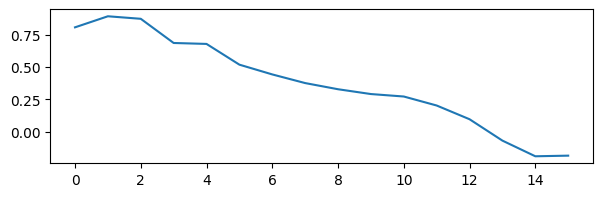

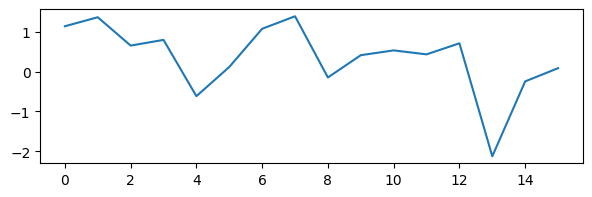

In [31]:
plt.figure(figsize=(7, 2))
plt.plot(X_train.iloc[5,0], label = "Original")
plt.figure(figsize=(7, 2))
plt.plot(X_train_noised.iloc[5,0], label = "Noised")

 24%|██▍       | 12/50 [00:01<00:04,  9.44it/s]


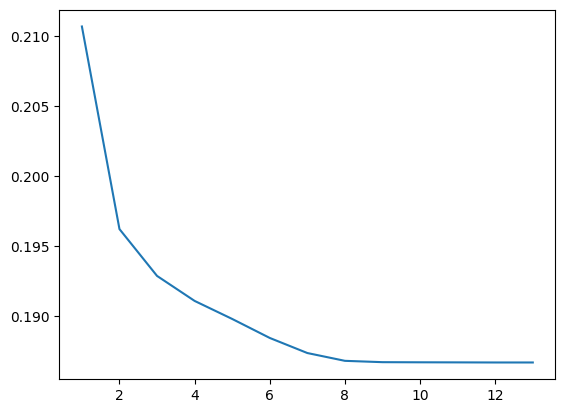

In [74]:
# add noise to X_train
X_train_noised = X_train + Epsilon

K = 9
p = 3
seuil = 1e-7
model = Mc2PCA(K, p, seuil, max_iter=50)
idx, E, info_by_cluster = model.fit(X_train_noised)
plt.plot(E)
plt.show()

Adjusted Rand Index: 0.2353967683005784
Precision: 0.5081081081081081
Recall: 0.4864864864864865


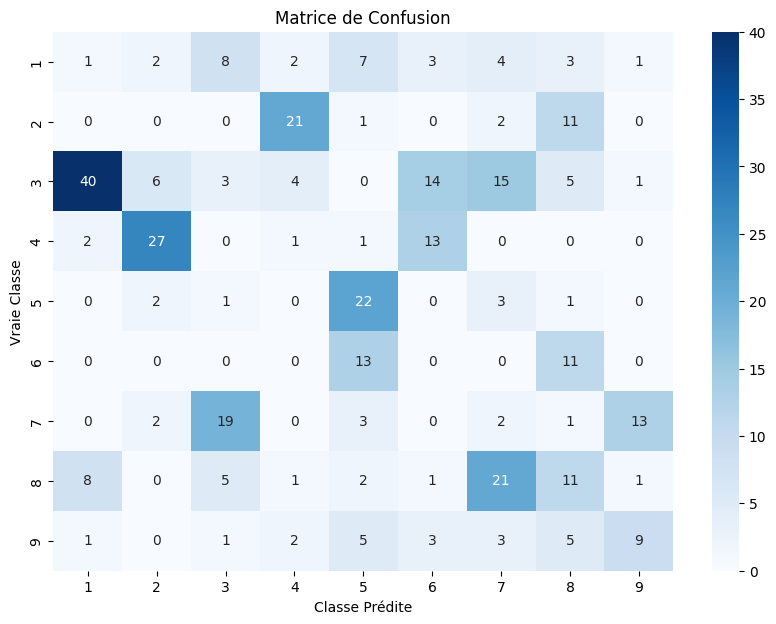

In [75]:
metrics(y_train, idx)

In [10]:
ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["noise factor","ARI mean","ARI std","Precision mean","Precision std","Recall mean","Recall std"])
for fact in [0,0.1,0.5,1,1.5,2,3,5]:
    print("factor:",fact)
    for i in tqdm(range(50)):
        X_test, y_test = load_japanese_vowels(return_X_y=True, split="train")
        X_train, y_train = load_japanese_vowels(return_X_y=True, split="test")
        np.random.seed(i)
        # shuffle rows
        X_train = X_train.sample(frac=1)
        y_train = y_train[X_train.index]

        Epsilon = np.empty_like(X_train)
        for i in range(Epsilon.shape[0]):
            for j in range(Epsilon.shape[1]):
                moy = X_train.iloc[i,j].mean()
                Epsilon[i, j] = moy*np.random.randn(len(X_train.iloc[i,j]))
        
        X_train_noised = X_train + fact*Epsilon

        K = 9
        p = 3
        seuil = 1e-7
        model = Mc2PCA(K, p, seuil, max_iter=50)
        idx, E, info_by_cluster = model.fit(X_train_noised)
        
        ari_score,precision,recall = metrics(y_train,idx)
        ari_scores.append(ari_score)
        precisions.append(precision)
        recalls.append(recall)

    df.loc[len(df)] = [fact,np.mean(ari_scores),np.std(ari_scores),np.mean(precisions),np.std(precisions),np.mean(recalls),np.std(recalls)]

print(df)

factor: 0


100%|██████████| 50/50 [01:51<00:00,  2.23s/it]


factor: 0.1


100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


factor: 0.5


100%|██████████| 50/50 [02:06<00:00,  2.54s/it]


factor: 1


100%|██████████| 50/50 [02:02<00:00,  2.45s/it]


factor: 1.5


100%|██████████| 50/50 [02:00<00:00,  2.40s/it]


factor: 2


100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


factor: 3


100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


factor: 5


100%|██████████| 50/50 [01:48<00:00,  2.17s/it]

   noise factor  ARI mean   ARI std  Precision mean  Precision std  \
0           0.0  0.242808  0.035285        0.517784       0.032996   
1           0.1  0.248665  0.038865        0.523270       0.037002   
2           0.5  0.273297  0.053141        0.538234       0.043760   
3           1.0  0.282227  0.053623        0.536081       0.042503   
4           1.5  0.282212  0.050619        0.528454       0.043411   
5           2.0  0.276546  0.049403        0.518982       0.046130   
6           3.0  0.269554  0.050347        0.509498       0.049782   
7           5.0  0.263147  0.051171        0.501574       0.051892   

   Recall mean  Recall std  
0     0.483459    0.035004  
1     0.490541    0.041358  
2     0.514541    0.054070  
3     0.524608    0.056020  
4     0.526184    0.053194  
5     0.523468    0.050881  
6     0.519012    0.050064  
7     0.514791    0.049524  


In [12]:
df

,noise factor,ARI mean,ARI std,Precision mean,Precision std,Recall mean,Recall std
0,0.0,0.242808,0.035285,0.517784,0.032996,0.483459,0.035004
1,0.1,0.248665,0.038865,0.523270,0.037002,0.490541,0.041358
2,0.5,0.273297,0.053141,0.538234,0.043760,0.514541,0.054070
3,1.0,0.282227,0.053623,0.536081,0.042503,0.524608,0.056020
4,1.5,0.282212,0.050619,0.528454,0.043411,0.526184,0.053194
5,2.0,0.276546,0.049403,0.518982,0.046130,0.523468,0.050881
6,3.0,0.269554,0.050347,0.509498,0.049782,0.519012,0.050064
7,5.0,0.263147,0.051171,0.501574,0.051892,0.514791,0.049524


In [11]:
df.to_csv("results/results_sensivity.csv")

In [32]:
df = pd.read_csv("results/results_sensivity.csv")

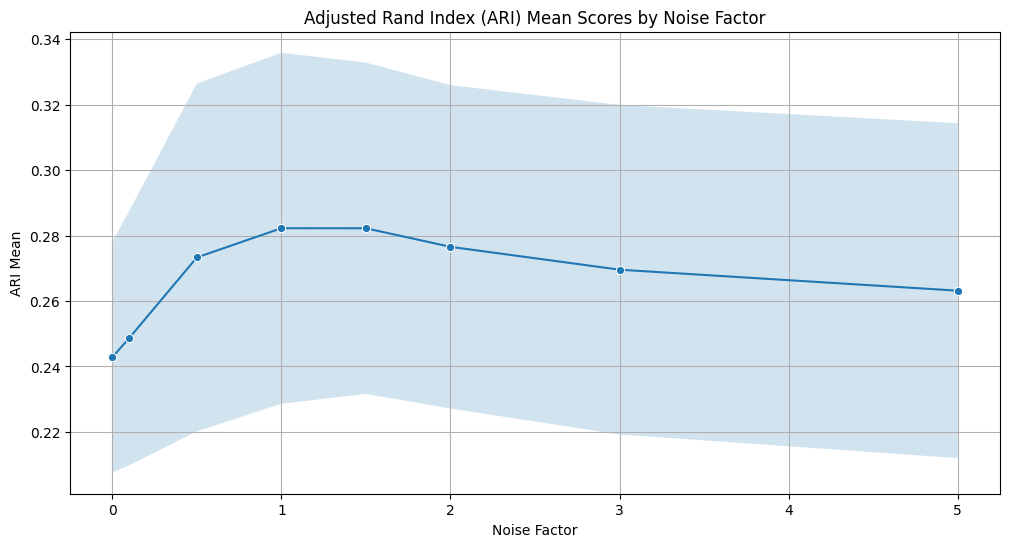

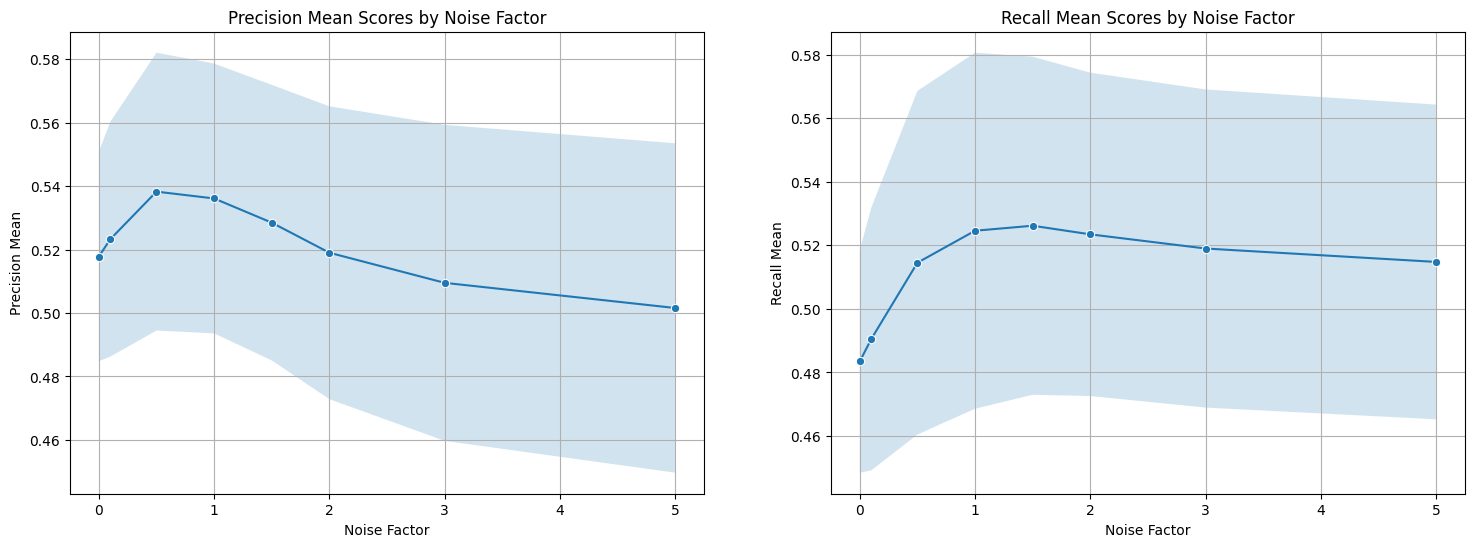

In [34]:
# # Remove the unnecessary 'Unnamed: 0' column if it's just an index
# if 'Unnamed: 0' in df.columns:
#     df.drop('Unnamed: 0', axis=1, inplace=True)

# Plotting the mean ARI score against the noise factor
plt.figure(figsize=(12, 6))

# Mean ARI plot
sns.lineplot(x='noise factor', y='ARI mean', data=df, marker='o')
plt.fill_between(df['noise factor'], df['ARI mean'] - df['ARI std'], df['ARI mean'] + df['ARI std'], alpha=0.2)
plt.title('Adjusted Rand Index (ARI) Mean Scores by Noise Factor')
plt.xlabel('Noise Factor')
plt.ylabel('ARI Mean')
plt.grid(True)
plt.show()

# Plotting Precision and Recall against the noise factor
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

# Precision plot
sns.lineplot(ax=axes[0], x='noise factor', y='Precision mean', data=df, marker='o')
axes[0].fill_between(df['noise factor'], df['Precision mean'] - df['Precision std'], df['Precision mean'] + df['Precision std'], alpha=0.2)
axes[0].set_title('Precision Mean Scores by Noise Factor')
axes[0].set_xlabel('Noise Factor')
axes[0].set_ylabel('Precision Mean')
axes[0].grid(True)

# Recall plot
sns.lineplot(ax=axes[1], x='noise factor', y='Recall mean', data=df, marker='o')
axes[1].fill_between(df['noise factor'], df['Recall mean'] - df['Recall std'], df['Recall mean'] + df['Recall std'], alpha=0.2)
axes[1].set_title('Recall Mean Scores by Noise Factor')
axes[1].set_xlabel('Noise Factor')
axes[1].set_ylabel('Recall Mean')
axes[1].grid(True)

plt.show()
